# Causes

author: steeve.laquitaine@epfl.ch  
last modified: 13-02-2024

**Method**:

* plot sorted spike locations 

* NOTE: plotting takes several minutes for some unit (this is impractical).


### Setup

1. Create or activate env `spikeinterf...`
2. Faster! Pre-compute data on cluster with: `sbatch cluster/analysis/sorting_quality.sh`

In [2]:
%load_ext autoreload
%autoreload 2
import os 
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import spikeinterface as si
from spikeinterface import comparison
import spikeinterface.core.template_tools as ttools
from spikeinterface.qualitymetrics import compute_quality_metrics as qm


# set project path
proj_path = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(proj_path)

from src.nodes import utils
from src.nodes.utils import get_config
from src.nodes.analysis.failures import accuracy as acc
from src.nodes.metrics import quality
from src.nodes.metrics.quality import get_scores_for_dense_probe as gscdp
from src.nodes.metrics.quality import get_chance_for_dense_probe as gchdp
from src.nodes.metrics.quality import combine_quality_across_dense_probe as cqadb

# PARAMETERS
DUR = 600 # 10 minutes recording
DT = 1.3 # ms (optimized)
THR_GOOD = 0.8

# DATASETS

# NPX PROBE
# biophy spont (10m)
cfg_ns, _ = get_config("silico_neuropixels", "concatenated").values()
KS4_ns_10m = cfg_ns["sorting"]["sorters"]["kilosort4"]["10m"]["output"] # KS4 sorting
GT_ns_10m = cfg_ns["sorting"]["simulation"]["ground_truth"]["10m"]["output"] # KS4 sorting
REC_ns = cfg_ns["probe_wiring"]["full"]["output"]  # Wired
PREP_ns = cfg_ns["preprocessing"]["full"]["output"]["trace_file_path"] # Preprocessed
STUDY_ns = cfg_ns["postprocessing"]["waveform"]["sorted"]["study"]["kilosort4"]["10m"] # WaveformExtractor

# synthetic
cfg_s, _ = get_config("buccino_2020", "2020").values()
REC_s = cfg_s["probe_wiring"]["full"]["output"]  # Wired

# pre-computed qualities
quality_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/analysis/sorting_quality/sorting_quality.csv"

# job parameters
job_kwargs = dict(n_jobs=-1, chunk_duration="1s", progress_bar=True)

# FIGURE SETTINGS
# ticks
N_MJ_TCKS = 5
N_MN_TCKS = 11

# colors
# quality colors
cl = {"good": [0.7, 0.1, 0.1], # strong red
      "oversplitter": [0.6, 0.9, 0.6], # blue
      "overmerger": [0, 0.7, 1], # green
      "mixed: good + overmerger": np.array([[0.7, 0.1, 0.1], [0, 0.7, 1]]).mean(axis=0),
      "mixed: good + oversplitter": np.array([[0.7, 0.1, 0.1], [0.6, 0.9, 0.6]]).mean(axis=0),
      "mixed: overmerger + oversplitter": np.array([[0.6, 0.9, 0.6], [0, 0.7, 1]]).mean(axis=0),
      "mixed: good + overmerger + oversplitter": np.array([[0.7, 0.1, 0.1], [0, 0.7, 1],[0.6, 0.9, 0.6]]).mean(axis=0),
      "false positive": [1,1,1] # white
}

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.001}
LG_FRAMEON = False              # no legend frame

2024-09-04 18:07:34,614 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-04 18:07:34,690 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-09-04 18:07:34,693 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-04 18:07:34,741 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Custom

In [132]:
def locate_spike_by_mt(we, job_kwargs: dict):
    """locate spikes
    - with monopolar_triangulation
    - both positive and negative peaks

    Returns:
        [('x', 'float64'),  ('y', 'float64'), ('z', 'float64'), ('alpha', 'float64')]
    """

    spike_loc = si.postprocessing.compute_spike_locations(
        we,
        load_if_exists=False,
        ms_before=0.5,
        ms_after=0.5,
        spike_retriver_kwargs={
            "channel_from_template": True,
            "peak_sign": "both",
            "radius_um": 50,
        },
        method="monopolar_triangulation",
        method_kwargs={},
        outputs="by_unit",
        **job_kwargs
    )
    return spike_loc[0]


def locate_spike_by_com(we, job_kwargs: dict):
    """locate spikes
    - with center of mass
    - both positive and negative peaks


    Returns:
        [('x', 'float64'),  ('y', 'float64')]
    """

    spike_loc = si.postprocessing.compute_spike_locations(
        we,
        load_if_exists=False,
        ms_before=0.5,
        ms_after=0.5,
        spike_retriver_kwargs={
            "channel_from_template": True,
            "peak_sign": "both",
            "radius_um": 50,
        },
        method="center_of_mass",
        method_kwargs={},
        outputs="by_unit",
        **job_kwargs
    )
    return spike_loc[0]


def plot_sites(ax, Probe):
    """ """

    ax.scatter(
        Probe.contact_positions[:, 0],
        Probe.contact_positions[:, 1],
        Probe.contact_positions[:, 2],
        marker="o",
        color="k",
        facecolors="none",
        s=0.1,
    )
    ax.set_xlabel("x: width", fontsize=20)
    ax.set_ylabel("y: depth", fontsize=20)
    ax.set_zlabel("z", fontsize=20)
    return ax


def plot_sites_xy(ax, Probe):
    """ """

    ax.scatter(
        Probe.contact_positions[:, 0],
        Probe.contact_positions[:, 1],
        marker="o",
        color="k",
        facecolors="none",
        s=1,
    )
    ax.set_xlabel("x: width", fontsize=20)
    ax.set_ylabel("y: depth", fontsize=20)
    return ax


def plot_spikes(ax, spike_loc, unit, title, color):
    spike_c = spike_loc[unit]
    for sp_i in range(len(spike_c)):
        ax.scatter(spike_c[sp_i][0], spike_c[sp_i][1], color=color, s=1)
    ax.set_title(title)
    return ax


def plot_spike_quality(ax, spike_loc, unit, title, quality, color_tp, color_fp):
    spike_c = spike_loc[unit]
    for sp_i in range(len(spike_c)):
        if quality[sp_i] == "TP":
            color = color_tp
        else:
            color = color_fp
        ax.scatter(spike_c[sp_i][0], spike_c[sp_i][1], color=color, s=1)
    ax.set_title(title)


def plot_waveforms(ax, we, max_chids, unit, before_ms, after_ms):

    # get waveforms
    wv, spike_ix = we.get_waveforms(unit_id=unit, with_index=True)

    # get channel ids (sparse)
    c_ids = we.sparsity.unit_id_to_channel_ids[unit]

    # get nearest channel
    max_chid = max_chids[unit]
    max_chid_ix = np.where(c_ids == max_chid)[0][0]

    # plot waveforms (num_spikes, num_samples, num_channels)
    ax.plot(wv[:5, :, max_chid_ix].T)
    ax.set_xticks([0, wv.shape[1], wv.shape[1]], [before_ms, 0, after_ms])
    ax.spines["right"].set_visible(False)
    return (ax, spike_ix, c_ids, max_chid)

### Sorted single-unit quality

* good: 24

In [8]:
Sorting = si.load_extractor(KS4_ns_10m)
n_spikes = Sorting.get_total_num_spikes()

/tmp/ipykernel_176538/3774929535.py:2: DeprecationWarning: Sorting.get_total_num_spikes() is deprecated and will be removed in spikeinterface 0.102, use sorting.count_num_spikes_per_unit()
  n_spikes = Sorting.get_total_num_spikes()


**brief stats**
(sorter: KS4, exp: NS)

* L1: 1 good unit, 2 oo units
* L2/3: 2 good, 14 oo
* L4: 24 good, 35 oo
* L5: 78 good, 297 oo
* L5: 27 good, 40 oo


In [11]:
MAX_NSPIKES = 600

# load quality results
unit_quality = pd.read_csv(quality_path)

# select a sorted unit and conditions
df_g = unit_quality[
    (unit_quality["quality"].str.contains("good"))
    & (unit_quality["experiment"] == "NS")
    & (unit_quality["sorter"] == "KS4")
    & (unit_quality["layer"] == "L4")
]
# get sparsest unit ids
# g_units = [unit for unit in df_g["sorted"] if n_spikes[unit] < MAX_NSPIKES]
# all
g_units = df_g["sorted"].values
print(len(g_units), "good units")

# poor units: mixed overmerger + oversplitter
df_oo = unit_quality[
    (unit_quality["quality"] == "mixed: overmerger + oversplitter")
    & (unit_quality["experiment"] == "NS")
    & (unit_quality["sorter"] == "KS4")
    & (unit_quality["layer"] == "L4")
]
# get sparsest unit ids
# oo_units = [unit for unit in df_oo["sorted"] if n_spikes[unit] < MAX_NSPIKES]
oo_units = df_oo["sorted"].values
print(len(oo_units), "oo units")

24 good units
35 oo units


In [10]:
df_oo

,sorted,quality,layer,sorter,experiment,Depth
21894,100,mixed: overmerger + oversplitter,L4,KS4,NS,NaN
21897,94,mixed: overmerger + oversplitter,L4,KS4,NS,NaN
21906,82,mixed: overmerger + oversplitter,L4,KS4,NS,NaN
21907,81,mixed: overmerger + oversplitter,L4,KS4,NS,NaN
21910,78,mixed: overmerger + oversplitter,L4,KS4,NS,NaN
21911,77,mixed: overmerger + oversplitter,L4,KS4,NS,NaN
21913,73,mixed: overmerger + oversplitter,L4,KS4,NS,NaN
21914,72,mixed: overmerger + oversplitter,L4,KS4,NS,NaN
21924,147,mixed: overmerger + oversplitter,L4,KS4,NS,NaN
21929,134,mixed: overmerger + oversplitter,L4,KS4,NS,NaN


### (21m/3s) locate all sorted spikes

* 10 minutes recording



In [11]:
# (0.5)once in the notebook
we = si.WaveformExtractor.load_from_folder(STUDY_ns)

In [12]:
# 28 minutes
LOAD = True
spike_path_by_mt = os.path.join(os.path.dirname(STUDY_ns), "spike_locations_mt.npy")
# get spike locations
if not LOAD:
    spike_loc_mt = locate_spike_by_mt(we, job_kwargs)
    np.save(spike_path_by_mt, spike_loc_mt)
spike_loc_mt = np.load(spike_path_by_mt, allow_pickle=True).item()

In [13]:
# (25s)
LOAD = True
spike_path_by_com = os.path.join(os.path.dirname(STUDY_ns), "spike_locations_com.npy")
# get spike locations
if not LOAD:
    spike_loc_com = locate_spike_by_com(we, job_kwargs)
    np.save(
        spike_path_by_com,
        spike_loc_com,
    )
spike_loc_com = np.load(spike_path_by_com, allow_pickle=True).item()

### (20s)Comparing COM vs MT methods

* The two produce very different results:
    * center-of-mass (COM) only produces 2D
    * monopolar_triangulation (MT) cam produce 3D but we plot 2D

* We will use MT method which is supposedly more accurate (see 3).
* for the first good unit

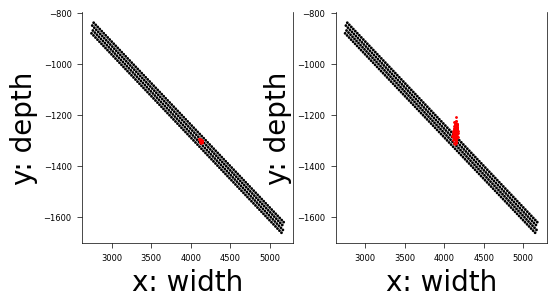

In [14]:
# unit index to show
UNIT = 0

# get probe
Probe = si.load_extractor(REC_ns).get_probe()

# plot COM
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(121)
ax = plot_sites_xy(ax, Probe)
spike_c = spike_loc_com[g_units[UNIT]]
for sp_i in range(len(spike_c)):
    ax.scatter(spike_c[sp_i][0], spike_c[sp_i][1], c="r", s=1)

# plot MT
ax = fig.add_subplot(122)
ax = plot_sites_xy(ax, Probe)
spike_c = spike_loc_mt[g_units[UNIT]]
for sp_i in range(len(spike_c)):
    ax.scatter(spike_c[sp_i][0], spike_c[sp_i][1], c="r", s=1)

### (50s)Good vs OO

* we use COM, more accurate (see 3).


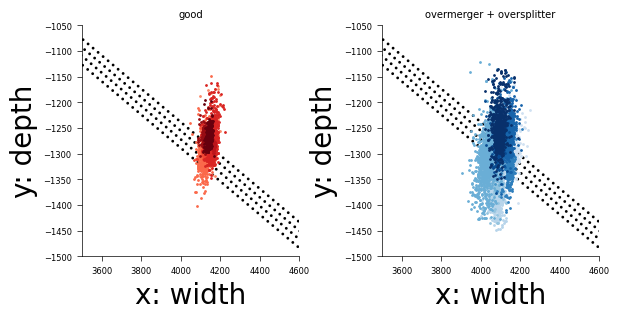

In [15]:
# nb of units to show
n_show = 11

# (20s)plot
fig = plt.figure(figsize=(6, 3))

# PANEL

# good units
ax = fig.add_subplot(121)
# sites
ax = plot_sites_xy(ax, Probe)
# spikes
cmap = plt.get_cmap("Reds")
colors = cmap(np.linspace(0, 1, n_show))
for g_i in range(len(g_units[:n_show])):
    ax = plot_spikes(ax, spike_loc_mt, g_units[g_i], "good", colors[g_i, :])
ax.spines["right"].set_visible(False)
ax.set_xlim([3500, 4600])
ax.set_ylim([-1500, -1050])


# PANEL

# overmerger-oversplitter units
ax = fig.add_subplot(122)
# sites
ax = plot_sites_xy(ax, Probe)
# spikes
cmap = plt.get_cmap("Blues")
colors = cmap(np.linspace(0, 1, n_show))
for o_i in range(len(oo_units[:n_show])):
    ax = plot_spikes(
        ax,
        spike_loc_mt,
        oo_units[o_i],
        "overmerger + oversplitter",
        colors[o_i, :],
    )
ax.spines["right"].set_visible(False)
ax.set_xlim([3500, 4600])
ax.set_ylim([-1500, -1050])
fig.tight_layout(**tight_layout_cfg)

### Plot spike quality

* SpikeInterface returns spikes quality only for the hungarian method which finds the best association between GT and tested units. With this method, both GT and tested units can be matched only to another unit, or not matched at all. That means that if two sorted units are a good match to a ground truth unit, the best is kept and the spikes of the other are FPs, even with a high agreement score.
* According to the definition of the agreement score a ground truth can only be matched by one sorted unit with > 80% accuracy, but we found example like unit 2219300 matched > 80% by sorted unit 114 and 119, which suggest that the same spikes are timestamped twice.

#### Precompute data

In [163]:
# WARNING!! Keep this parametrization. It is compatible
# with our classification of the sorted units.
# evaluate spikes.
SortingTrue = si.load_extractor(GT_ns_10m)
SortingTrue = SortingTrue.remove_empty_units()
Sorting = si.load_extractor(KS4_ns_10m)
comp = comparison.compare_sorter_to_ground_truth(
    SortingTrue,
    Sorting,
    match_mode="hungarian",
    exhaustive_gt=True,
    delta_time=1.3,
    compute_labels=True,
    compute_misclassifications=False,
    well_detected_score=0.8,
    match_score=0.8,  # modified
    redundant_score=0.2,  # default - we don't use that info in this analysis
    overmerged_score=0.2,  # default - we don't use that info in this analysis
    chance_score=0.1,  # default - we don't use that info in this analysis
)

# get unit nearest channel (with extremum amplitude)
max_chids = ttools.get_template_extremum_channel(we, peak_sign="both")

# quality metrics
metrics = qm(we, metric_names=["snr", "isi_violation"])

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/qualitymetrics/quality_metric_calculator.py:132: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  metrics.loc[non_empty_unit_ids, col] = pd.Series(res[i])


#### Good unit

* **Spike locations**:
    * observations:
        * For good units, spikes are **locally concentrated** and spurious spikes seem to be at the boundaries of the spike cloud.
            * spread exceptions are unit 61, 84.
            * the degree of concentration seems to positively predict the agreement score.
        * spike cloud seem largely spread for poor units

* **Waveforms**:
    * method:
        * a subset of spikes (500) were sampled. To get a sparse matrix (faster), only 28 sites were extracted 
        * dense waveforms are extracted first using a small number of 100 spikes (5)
    * observations:
        * waveforms overlap very well (low variability)
        * a single amplitude
        * negative peaks are strongly aligned
        * negative peaks have same amplitude

unit 76
best score: 0.972972972972973
firing rate: 0.37
qmetrics:
 isi_violations_ratio     0.000000
isi_violations_count     0.000000
snr                     36.164197
Name: 76, dtype: float64


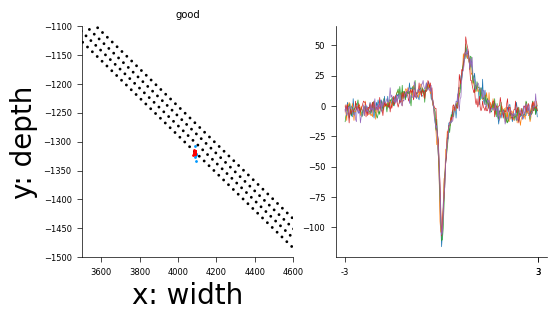

In [167]:
# (20s)
UNIT_IX = 12

# PANEL

# plot
fig = plt.figure(figsize=(6, 3))
# good units
ax = fig.add_subplot(121)
# sites
ax = plot_sites_xy(ax, Probe)
# spikes
quality = comp.get_labels2(g_units[UNIT_IX])[0]
plot_spike_quality(
    ax, spike_loc_mt, g_units[UNIT_IX], "good", quality, "r", [0, 0.6, 1]
)
ax.spines["right"].set_visible(False)
ax.set_xlim([3500, 4600])
ax.set_ylim([-1500, -1100])
print(f"unit {g_units[UNIT_IX]}")
# print(f"unit {g_units[UNIT_IX]}'s spike quality:", quality)
print("best score:", sum(quality == "TP") / len(quality))
print("firing rate:", n_spikes[g_units[UNIT_IX]] / 600)
print("qmetrics:\n", metrics.iloc[g_units[UNIT_IX]])

# PANEL

ax = fig.add_subplot(122)
ax = plot_waveforms(ax, we, max_chids, g_units[UNIT_IX], -3, 3)

#### Poor unit

* **Spike locations**:
    * observations
        * unit 56, 86, 147 have a lot of TP, but below 80%.
        * unit 120 is locally concentrated.


* **Waveforms**
    * observations:
        * negative peaks have different cluster of amplitudes
        * negative peaks can be shifted for different cluster or not
        * low amplitude extremum (or negative peaks)?
            * exceptions (unit 78)

note: very aligned negative peaks can produce widely spread spike locations (unit 78). They are independent.

unit 77
best score: 0.0
firing rate: 2.6866666666666665
qmetrics:
 isi_violations_ratio    0.000000
isi_violations_count    0.000000
snr                     1.849451
Name: 77, dtype: float64


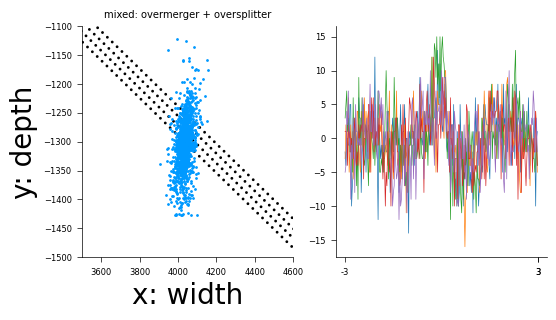

In [168]:
UNIT_IX = 5

# PANEL

# (20s)plot
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(121)
ax = plot_sites_xy(ax, Probe)
quality = comp.get_labels2(oo_units[UNIT_IX])[0]
plot_spike_quality(
    ax,
    spike_loc_mt,
    oo_units[UNIT_IX],
    "mixed: overmerger + oversplitter",
    quality,
    "r",
    [0, 0.6, 1],
)
ax.spines["right"].set_visible(False)
ax.set_xlim([3500, 4600])
ax.set_ylim([-1500, -1100])
print(f"unit {oo_units[UNIT_IX]}")
# print(f"unit {oo_units[UNIT_IX]}'s spike quality:", quality)
print(
    "best score:", sum(quality == "TP") / len(quality)
)  # TODO: report best agreement score here instead
print("firing rate:", n_spikes[oo_units[UNIT_IX]] / 600)
print("qmetrics:\n", metrics.iloc[oo_units[UNIT_IX]])

# PANEL

ax = fig.add_subplot(122)
ax = plot_waveforms(ax, we, max_chids, oo_units[UNIT_IX], -3, 3)

### Some sorted units are "good" but contain duplicate timestamps for the same GT spikes.

* Sorted units: 
    * L4 (2 over 24 units):
        * 114 and 119 (L4) and GT 2219300 .
        * 121 
    * 355 ... (L5)

* consequently all the spikes of sorted unit 114 are labelled as a false positive, by the "Hungarian" method.

unit 114 quality: ['mixed: good + overmerger + oversplitter']
unit 114 spike qualities: [array(['FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP',
       'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP',
       'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP',
       'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP',
       'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP',
       'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP',
       'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP',
       'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP',
       'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP',
       'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP',
       'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP',
       'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP',
       'FP', 'FP', 'FP', 'FP', 'FP'

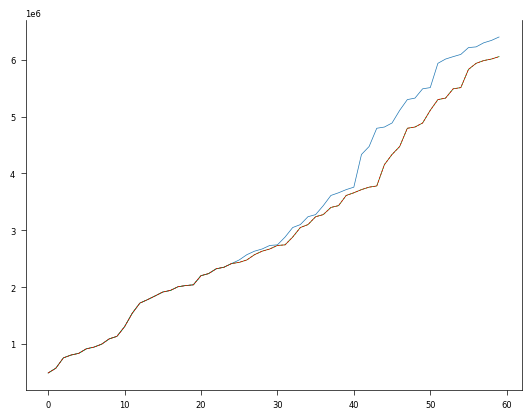

In [20]:
quality = comp.get_labels2(114)
print("unit 114 quality:", df_g[df_g["sorted"] == 114]["quality"].values)
print("unit 114 spike qualities:", quality)

# both sorted units have high agreement score
print("score unit 114:", comp.agreement_scores.loc[2219300, 114])
print("score unit 119:", comp.agreement_scores.loc[2219300, 119])

# check duplicate sorted unit timestamps
ttp114 = Sorting.get_unit_spike_train(unit_id=114)
ttp119 = Sorting.get_unit_spike_train(unit_id=119)
ttp2219300 = SortingTrue.get_unit_spike_train(unit_id=2219300)

plt.plot(ttp114[:60])
plt.plot(ttp119[:60], "g")
plt.plot(ttp2219300[:60], "r--")

# calculate distance between GT and sorted unit spikes
# at the start, GT spikes are timestamped twice (once by each unit) within
# the surrounding 1.3ms interval.
distance_114_ms = (ttp2219300[:40] - ttp114[:40]) * 1000 / 40000
distance_119_ms = (ttp2219300[:40] - ttp119[:40]) * 1000 / 40000
print("ttp 119 to tto 2219300:", distance_119_ms)
print("ttp 114 to tto 2219300:", distance_114_ms)

In [405]:
max(comp.agreement_scores.loc[:, 45])

0.7567340067340067

### 3D-plot (MT)

* It should not be possible to derive the z-coord of sorted spikes as spike amplitudes change along the x-y plane for a 2D neuropixels probe. There is no information about the z-coordinate.

%matplotlib widget must be before and in a separate cell

In [36]:
%matplotlib widget

In [53]:
# import mpl_toolkits

# # plot electrodes and spikes
# Rec = si.load_extractor(REC_ns)
# Probe = Rec.get_probe()
# fig = plt.figure(figsize=(6, 6))
# ax = fig.add_subplot(111, projection="3d")
# ax = plot_sites(ax, Probe)
# # spikes
# spike_c = spike_loc_mt[unit_id]
# for sp_i in range(len(spike_c)):
#     ax.scatter(spike_c[sp_i][0], spike_c[sp_i][1], spike_c[sp_i][2], c="r", s=1)

### References

(1) https://neuronaldynamics.epfl.ch/online/Ch7.S2.html  
(2) https://spikeinterface.readthedocs.io/en/stable/modules/sortingcomponents.html#peak-localization  
(3) https://www.eneuro.org/content/eneuro/11/2/ENEURO.0229-23.2023.full.pdf  
(4) https://spikeinterface.readthedocs.io/en/0.100.5/api.html?highlight=get_waveforms#spikeinterface.core.WaveformExtractor.get_waveforms   
(5) https://spikeinterface.readthedocs.io/en/0.100.0/modules_gallery/core/plot_4_waveform_extractor.html